Import Libraries

In [ ]:
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
import keras.backend as K
import datetime
import cv2

import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from IPython import display
display.clear_output()

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4004273690574291784
xla_global_id: -1
]


Some Functions

In [ ]:
def generate_data(n,  r1= (-2,2), r2= (-4,4), m= np.array([0.0,0.0]), c= np.array([[0.3,-0.5],[-0.5,2]]), export_path="./data/train.scv", verbose = 1):

    # generate data
    x = np.random.rand(n, 2)
    x[:, 0] = x[:, 0] * (r1[1] - r1[0]) + r1[0]
    x[:, 1] = x[:, 1] * (r2[1] - r2[0]) + r2[0]

    # calculate gaussian
    y = multivariate_normal.pdf(x, mean = m, cov=c)

    # debug
    if verbose == 1:
        print("x1: ", np.min(x[:, 0]), np.max(x[:, 0]))
        print("x2: ", np.min(x[:, 1]), np.max(x[:, 1]))
        print("x shape: ", x.shape)
        print("y: ", np.min(y), np.max(y))
        print("y shape: ", y.shape)
    # if

    # save data
    db_table = dict(
        data = {"x1": x[:, 0], "x2": x[:, 1], "y": y},
        columns = ["x1", "x2", "y"]
    )

    ds_data = pd.DataFrame(**db_table)

    save_dir = os.path.dirname(export_path)
    if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
    ds_data.to_csv(export_path, index=False)

    return ds_data
# generate_dataset

def load_data(csv_file):
    df_data  = pd.read_csv(csv_file)
    return df_data[["x1", "x2"]].values, df_data[["y"]].values.flatten()
# load_data

def load_dataset(csv_train = "./data/train.csv",
                 csv_valid = "./data/valid.csv",
                 csv_test  = "./data/test.csv"):
    # test
    x_test, y_test = load_data(csv_test)

    #train
    x_train, y_train = load_data(csv_train)

    #valid
    x_valid, y_valid = load_data(csv_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test
# load_dataset

def visualize_dataset(x, y, color = "green", title = "Training Data\n", ax = None):
    if ax is None:
        plt.figure(figsize=(16, 6))
        ax = plt.subplot(1,2,1, projection='3d')
    # if

    surf = ax.scatter(x[:,0], x[:,1], y, c = color)
    ax.set_frame_on
    ax.set_xlabel('x1', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_ylabel('x2', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_zlabel("y", labelpad = 5, fontdict=dict(fontsize = 14))
    plt.legend(['Gaussian values'])
    plt.title(title, fontdict=dict(fontsize = 20))
# visualize_dataset

def normalize_data(x_train, x_valid, x_test):
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv",
                                                                      csv_valid="./data/valid.csv",
                                                                      csv_test="./data/test.csv")
    v_mean, v_std = None, None

    # Visualize data
    print("*******************")
    print("Befor Normalization")
    print("*******************")
    print("Train min=%.3f, max=%.3f" % (x_train.min(), x_train.max()))
    print("Valid min=%.3f, max=%.3f" % (x_valid.min(), x_valid.max()))
    print("Test min=%.3f, max=%.3f" % (x_test.min(), x_test.max()))

    # Visualize data
    if v_mean is None and v_std is None: # Prevent normalization with many times
        v_mean = np.mean(x_train, axis = 0)
        v_std  = np.std(x_train, axis = 0)

        x_train = (x_train - v_mean) / v_std
        x_valid = (x_valid - v_mean) / v_std
        x_test  = (x_test - v_mean) / v_std
    # if
    print("\n\n")
    print("Mean = %s, Std = %s"%(str(v_mean), str(v_std)))

    print("*******************")
    print("After Normalization")
    print("*******************")
    print("Train min=%.3f, max=%.3f" % (x_train.min(), x_train.max()))
    print("Valid min=%.3f, max=%.3f" % (x_valid.min(), x_valid.max()))
    print("Test min=%.3f, max=%.3f" % (x_test.min(), x_test.max()))

    return x_train, x_valid, x_test
# build_data

def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title("Mean Squared Error")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history['val_loss'], color="orange", label='test')
# summarize_diagnostics

def visualize_logs(visualize_data, group_data, figsize = (10, 5), is_show = True, label_size = 12, title_size = 16, save_path = None):
    """
    visualize_data = df_logs[50:].to_dict(orient='list')
    group_data     = [{"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                       "title": "Error at Epoch {epoch}: {val_mean_squared_error:.4f}\n",
                       "style": "min"},
                      {"x": "epoch", "y": ["loss", "val_loss"],
                       "title": "Loss at Epoch {epoch}: {val_loss:.4f}\n",
                       "style": "min"}]
    figsize        = (10, 5)
    visualize_logs(visualize_data, group_data, figsize)
    """
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt, numpy as np

    fig = plt.figure(figsize=figsize)
    for idx, group in enumerate(group_data):
        x_axis_name, y_axis_names, title, style = group["x"], group["y"], group["title"], group["style"]
        x_values = visualize_data[x_axis_name]
        end_logs = dict([(x_axis_name, x_values[-1])])

        ax = plt.subplot(1, len(group_data), idx%len(group_data) + 1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        for y_axis_name in y_axis_names:
            y_values = visualize_data[y_axis_name]
            if style is not None and style != "":
                y_values = []
                for i in range(len(visualize_data[y_axis_name])):
                    if style == "median":
                        y_values.append(np.median(visualize_data[y_axis_name][:i+1]))
                    elif style == "avg":
                        y_values.append(np.average(visualize_data[y_axis_name][:i+1]))
                    elif style == "max":
                        y_values.append(np.max(visualize_data[y_axis_name][:i+1]))
                    elif style == "min":
                        y_values.append(np.min(visualize_data[y_axis_name][:i+1]))
            # if
            end_logs.update(dict([(y_axis_name, y_values[-1])]))
            ax.plot(x_values, y_values)
        pass
        title = title.format(**end_logs)

        ax.set_xlabel(x_axis_name, fontsize = label_size)
        ax.legend(y_axis_names, loc='upper left', fontsize = label_size)
        ax.set_title(title, fontsize = title_size)
    # for

    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
        fig.savefig(save_path)
    # if

    if is_show == True:
        plt.show()
        return None
    return fig
# visualize_logs

# 1. DATASET

1.1. Generate data

In [ ]:
rangex1 = (-2,2)
rangex2 = (-4,4)
mean = np.array([0.0,0.0])
cov = np.array([[0.3,-0.5],[-0.5,2]])

generate_data(n=20000, r1=rangex1, r2=rangex2, m=mean, c=cov, export_path="./data/train.csv", verbose = 1);
generate_data(n=100, r1=rangex1, r2=rangex2, m=mean, c=cov, export_path="./data/test.csv", verbose = 1);
generate_data(n=100, r1=rangex1, r2=rangex2, m=mean, c=cov, export_path="./data/valid.csv", verbose = 1);

x1:  -1.9996862270628126 1.999987919857884
x2:  -3.999274649732868 3.9991260729086386
x shape:  (20000, 2)
y:  5.4258386744807455e-14 0.2688825764991255
y shape:  (20000,)
x1:  -1.9936158157639379 1.953323683343199
x2:  -3.8987321881133727 3.982341569206196
x shape:  (100, 2)
y:  1.1070322962061738e-12 0.24655682582719157
y shape:  (100,)
x1:  -1.9998057075848235 1.9979058743790055
x2:  -3.884463074508713 3.9311468410396575
x shape:  (100, 2)
y:  4.511888399801452e-10 0.22975657067606395
y shape:  (100,)


1.2. Load dataset

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

In [ ]:
from google.colab import files

# Tải file về máy
files.download('./data/train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.3. Visualize dataset

Training samples:  20000  -- Shape:  (20000, 2) (20000,)
Validating samples:  100  -- Shape:  (100, 2) (100,)
Testing samples:  100  -- Shape:  (100, 2) (100,)


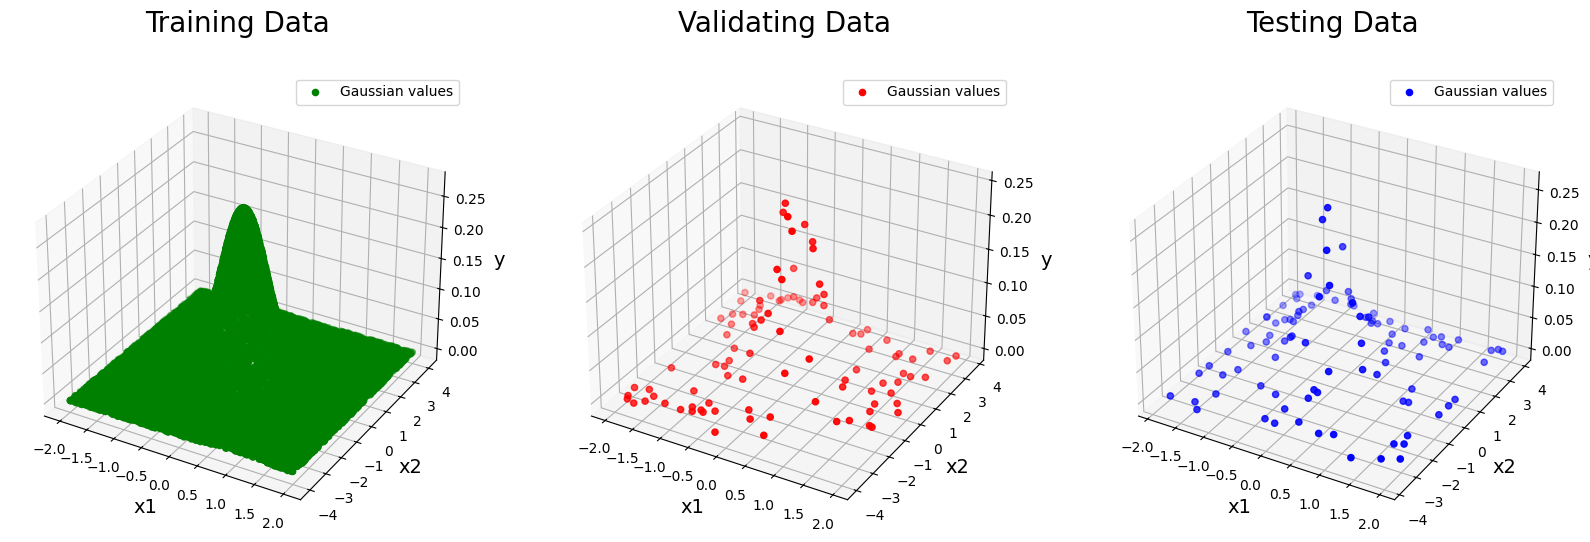

In [ ]:
print("Training samples: ", len(x_train), " -- Shape: ", x_train.shape, y_train.shape)
print("Validating samples: ", len(x_valid), " -- Shape: ", x_valid.shape, y_valid.shape)
print("Testing samples: ", len(x_test), " -- Shape: ", x_test.shape, y_test.shape)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,3,1, projection='3d')
visualize_dataset(x_train, y_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,3,2, projection='3d')
visualize_dataset(x_valid, y_valid, color = "red", title = "Validating Data\n", ax = ax2)

ax3 = plt.subplot(1,3,3, projection='3d')
visualize_dataset(x_test, y_test, color = "blue", title = "Testing Data\n", ax = ax3)

2. NETWORK STRUCTURE

In [ ]:
def build_model(H=10):
    inp = Input(shape=(2,), name='Input')
    x = Dense(units=H, activation='sigmoid', name='fc')(inp)
    output_label = Dense(units=1, activation='sigmoid', name='gauss_apxm')(x)

    model = Model(inputs=inp, outputs=output_label)
    model.summary()
    return model
#model

In [ ]:
# build a sample model with hidden node = 10
model = build_model(H=10)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

3. EXPERIMENT 1:

3.1. Train Data

Train: x-shape = (200, 2) y-shape = (200,)
Valid: x-shape = (100, 2) y-shape = (100,)


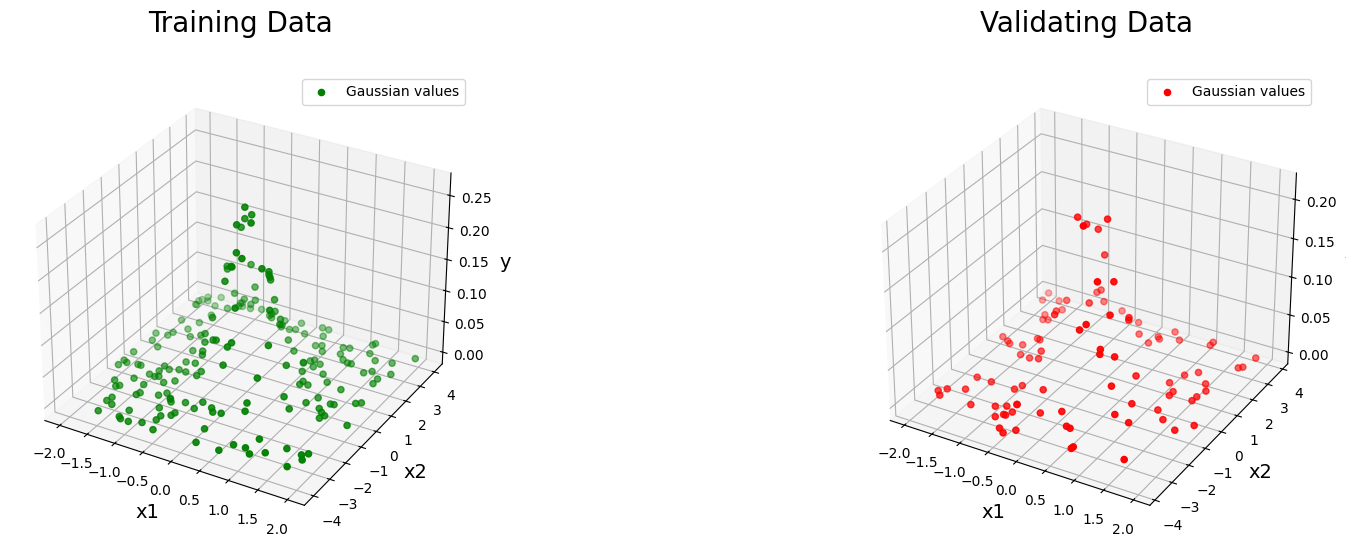

In [ ]:
x_exp1_train, y_exp1_train = x_train[:200], y_train[:200]
x_exp1_valid, y_exp1_valid = x_valid, y_valid

print(f"Train: x-shape = {x_exp1_train.shape} y-shape = {y_exp1_train.shape}")
print(f"Valid: x-shape = {x_exp1_valid.shape} y-shape = {y_exp1_valid.shape}")

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,2,1, projection='3d')
visualize_dataset(x_exp1_train, y_exp1_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,2,2, projection='3d')
visualize_dataset(x_exp1_valid, y_exp1_valid, color = "red", title = "Validating Data\n", ax = ax2)

3.2. Model

In [ ]:
exp1_model = build_model(H=10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

3.3. Training

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

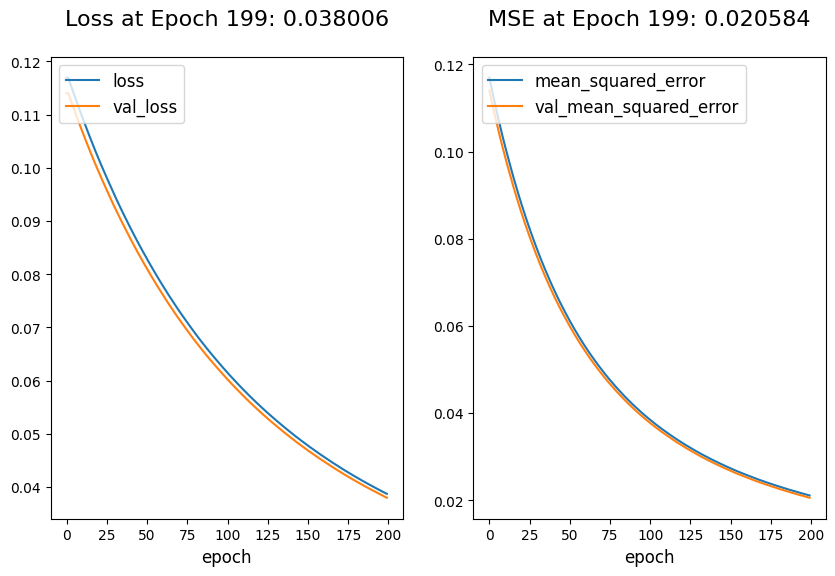

> training time is 2.2469 minutes


In [ ]:
K.clear_session()
exp1_model = build_model(H=10)

# OPTIMIZATION
exp1_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

# CALLBACKS
callbacks = []

# + ModelCheckPoint
save_dir = "./data/model/train_01"
template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
if os.path.exists(save_dir) == False: os.makedirs(save_dir)
modekcheckpoint_callback = ModelCheckpoint(
    filepath=os.path.join(save_dir, template_name),
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)
callbacks.append(modekcheckpoint_callback)

# + Early Stopping
earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
callbacks.append(earlystopping_callback)


# + Visualize logs
review_logs = {}
def custom_on_epoch_end(self, epoch, logs, **kwargs):
    review_logs = kwargs["review_logs"]
    if epoch == 0:
        review_logs["epoch"] = [epoch]
        for key in logs.keys(): review_logs[key] = [logs[key]]
    # if
    review_logs["epoch"].append(epoch)
    for key in logs.keys(): review_logs[key].append(logs[key])

    visualize_data = review_logs
    group_view     = [{"x": "epoch", "y": ["loss", "val_loss"],
                       "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                       "style": "median"},
                      {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                       "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                       "style": None}
                     ]
    fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False, save_path = os.path.join("./data/model/train_01", "logs.png"))
    plt.close()
    if epoch == 0:
        display.display(fig, display_id="logs")
    else:
        display.update_display(fig, display_id="logs")
    pass
# custom_on_epoch_end

custom_callbacks = LambdaCallback()
custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
callbacks.append(custom_callbacks)

# TRAINING
batch_size = 128
epochs = 200

starting_time = time.time()
history = exp1_model.fit(x_exp1_train, y_exp1_train,
                    validation_data=(x_exp1_valid, y_exp1_valid),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks,
                    verbose = 0)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

3.4. Evaluating

In [ ]:
epoch_opt = np.argmin(history.history["val_mean_squared_error"])

In [ ]:
save_name = template_name.format(epoch = epoch_opt + 1,
                 val_mean_squared_error = history.history["val_mean_squared_error"][epoch_opt],
                 val_loss= history.history["val_loss"][epoch_opt])
save_path = os.path.join(save_dir, save_name)
save_path

'./data/model/train_01/funcApxm_model_01_200_0.021_val_acc-0.021.keras'

Test loss: 0.02083693817257881
Test accuracy: 0.02083693817257881


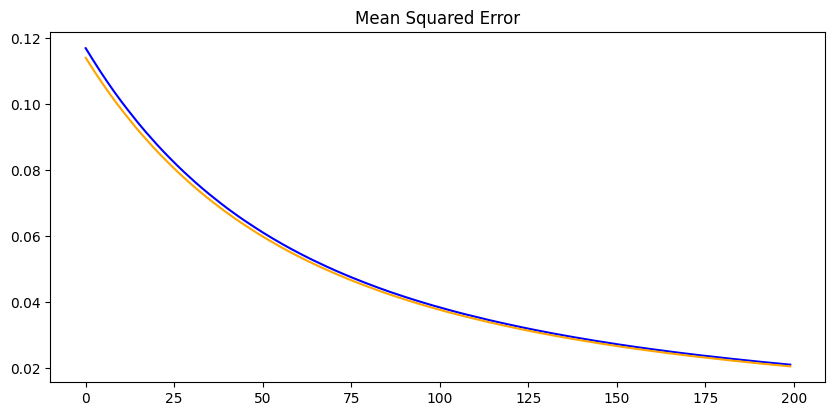

In [ ]:
from keras.models import load_model
model = load_model(save_path)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
summarize_diagnostics(history)

3.5. Discussion

Training with HiddenNode = 10, Maximum Epochs = 200, EarlyStopping = 10

No overfit and achieve optimization error at epoch = 200 with accuracy = 0.011924168094992638

# 4. EXPERIMENT 2:

Setup:

E* = 200

H = 10

N = 0 --> 2000, step = 200

4.1. Train Data

In [ ]:
x_exp2_train, y_exp2_train = [], []
x_exp2_valid, y_exp2_valid = x_valid, y_valid
print("Train: ")
for size in range(200, 2001, 200):
    x_exp2_train.append(x_train[:size])
    y_exp2_train.append(y_train[:size])
    print(f"+ Size: {size} {x_exp2_train[-1].shape} {y_exp2_train[-1].shape}")
# for
print(f"Valid: {x_exp2_valid.shape} {y_exp2_valid.shape}")

Train: 
+ Size: 200 (200, 2) (200,)
+ Size: 400 (400, 2) (400,)
+ Size: 600 (600, 2) (600,)
+ Size: 800 (800, 2) (800,)
+ Size: 1000 (1000, 2) (1000,)
+ Size: 1200 (1200, 2) (1200,)
+ Size: 1400 (1400, 2) (1400,)
+ Size: 1600 (1600, 2) (1600,)
+ Size: 1800 (1800, 2) (1800,)
+ Size: 2000 (2000, 2) (2000,)
Valid: (100, 2) (100,)


4.2. Build model

In [ ]:
exp2_model = build_model(H = 10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

4.3. Training

In [ ]:
def train_model(train_id, x_local_train, y_local_train,
                x_local_valid, y_local_valid, nb_epochs = 1000):

    K.clear_session()
    exp2_model = build_model(H=10)

    # OPTIMIZATION
    exp2_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"./data/model/train_02/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(
        filepath=os.path.join(save_dir, template_name),
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode='auto'
    )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"],
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                           "style": "median"},
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False,
                             save_path = os.path.join(f"./data/model/train_02/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = exp2_model.fit(x_local_train, y_local_train,
                        validation_data=(x_local_valid, y_local_valid),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = callbacks,
                        verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history
# train_model

Train id: 0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

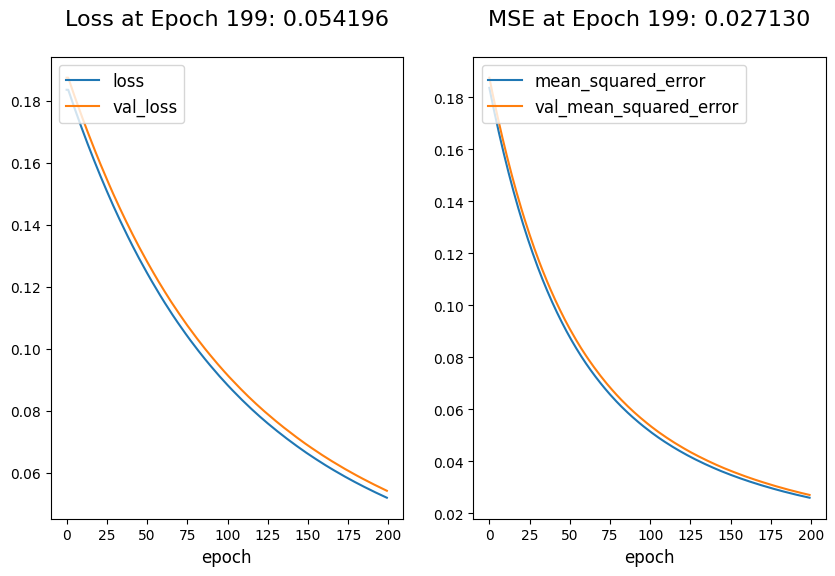

> training time is 2.3381 minutes
Train id: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

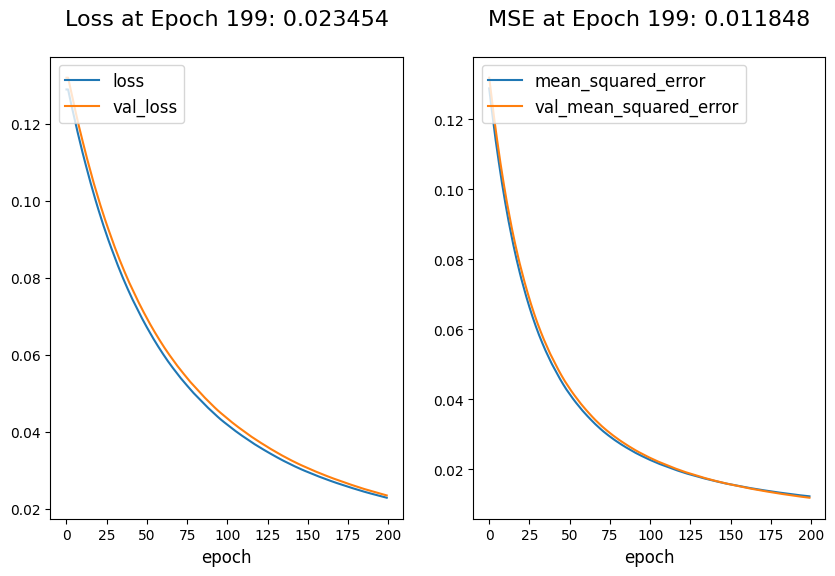

> training time is 2.2132 minutes
Train id: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

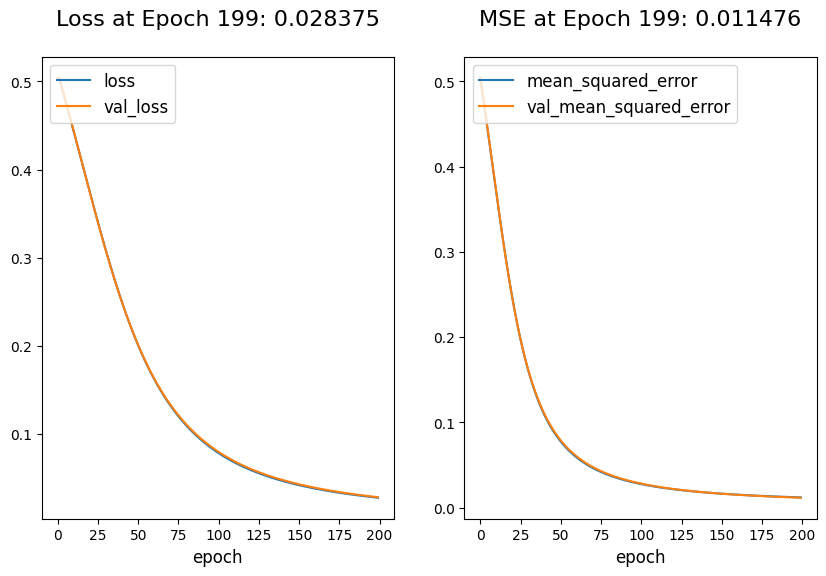

> training time is 2.1946 minutes
Train id: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

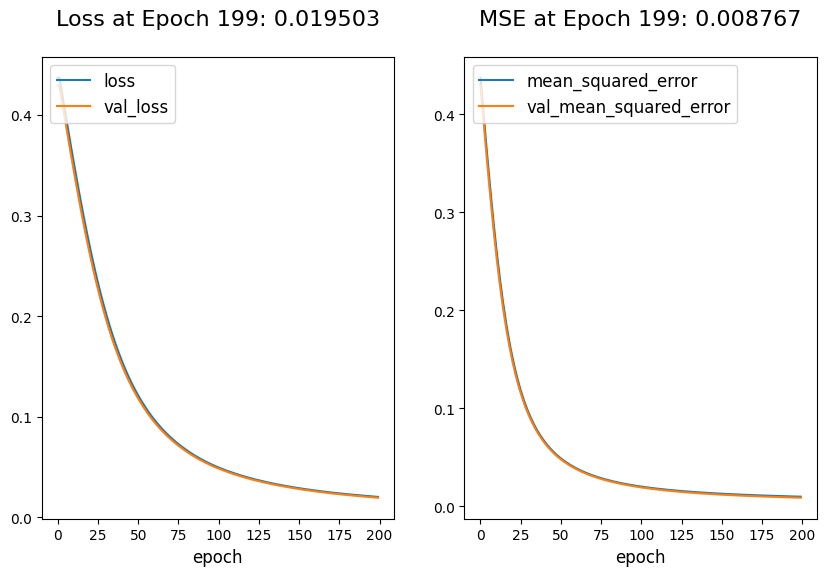

> training time is 2.1877 minutes
Train id: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

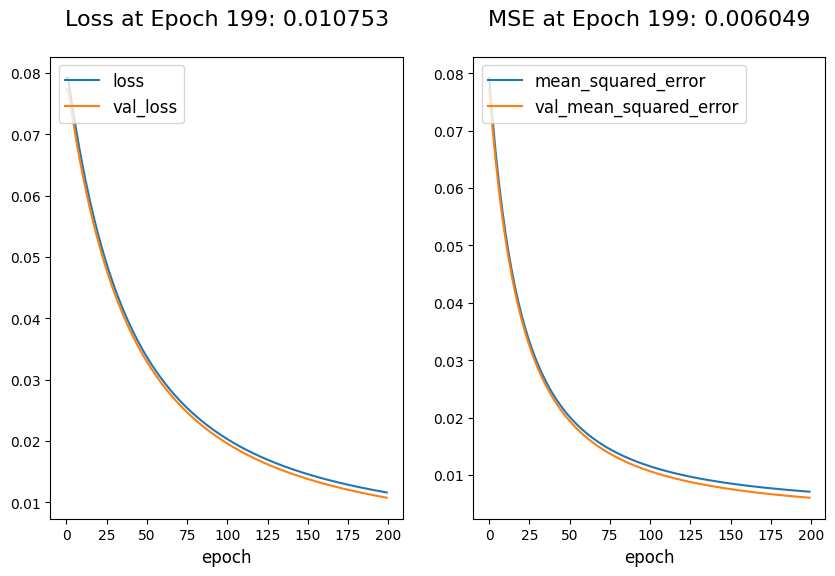

> training time is 2.1890 minutes
Train id: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

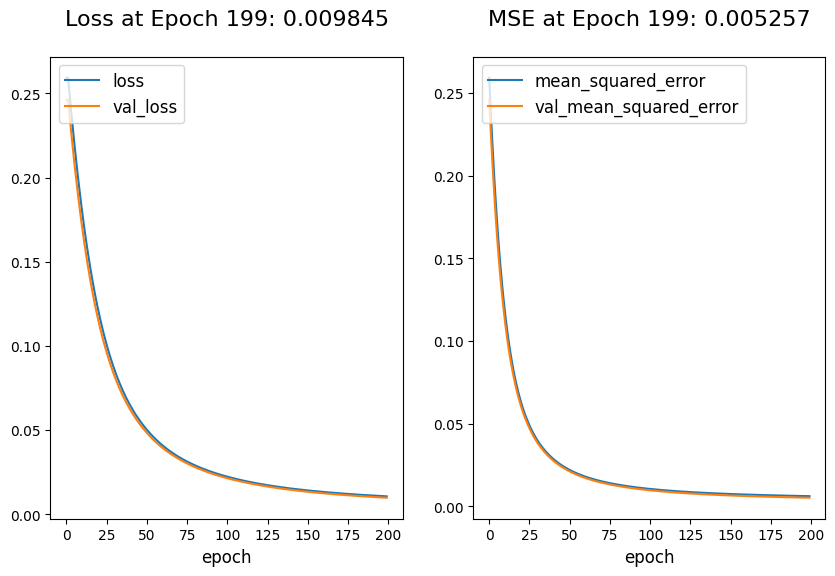

> training time is 2.1377 minutes
Train id: 6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

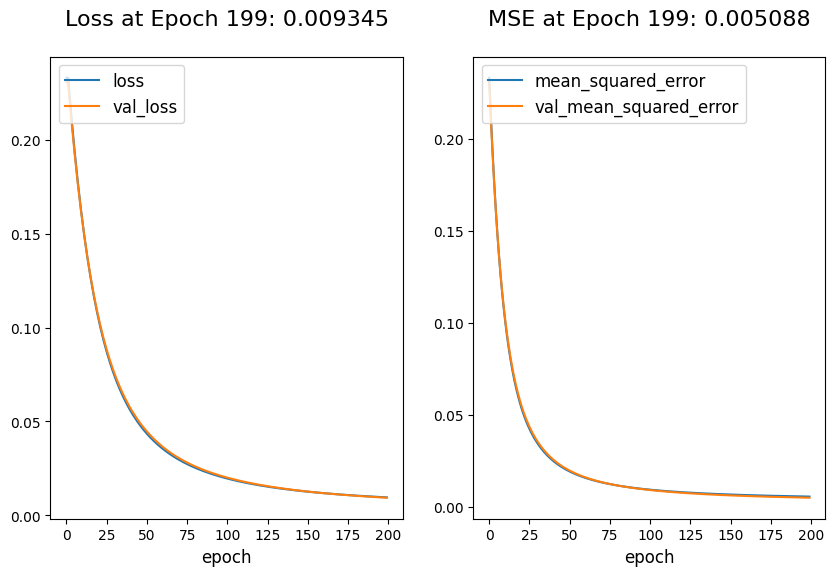

> training time is 2.0967 minutes
Train id: 7


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

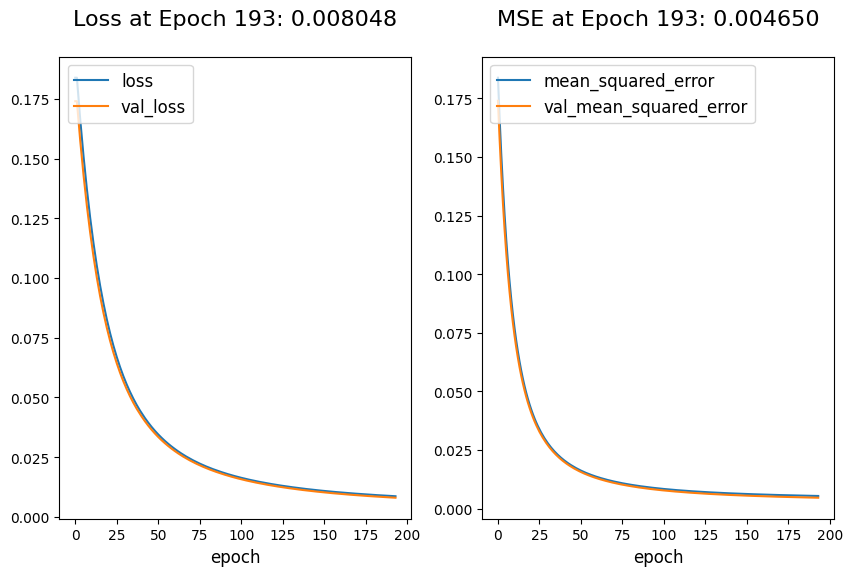

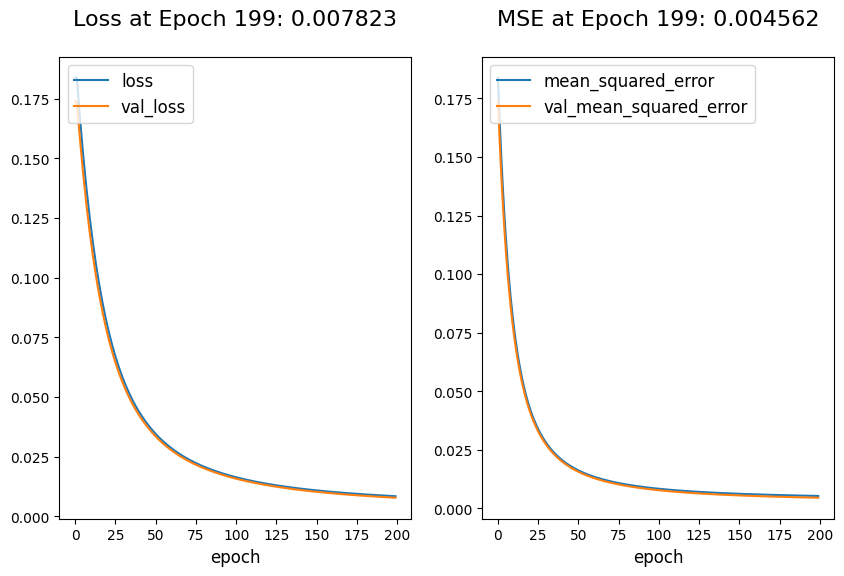

> training time is 2.1884 minutes
Train id: 8


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

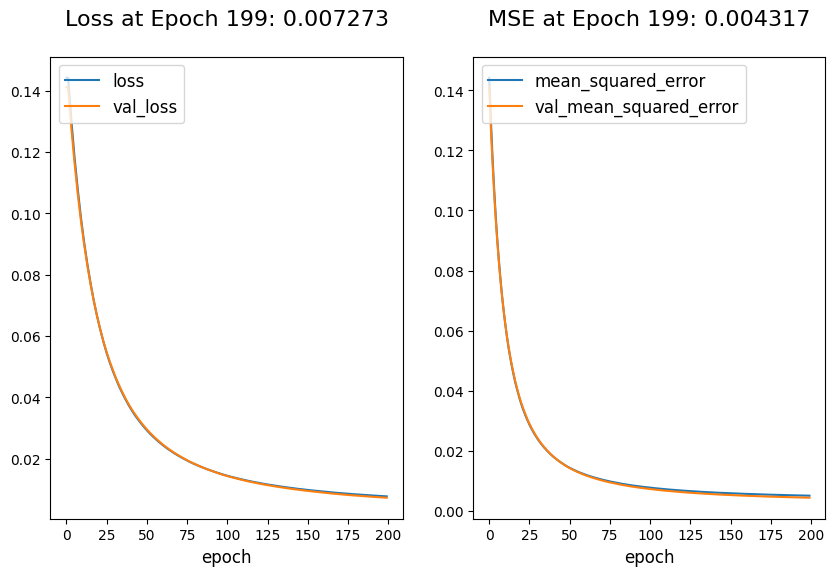

> training time is 2.2047 minutes
Train id: 9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

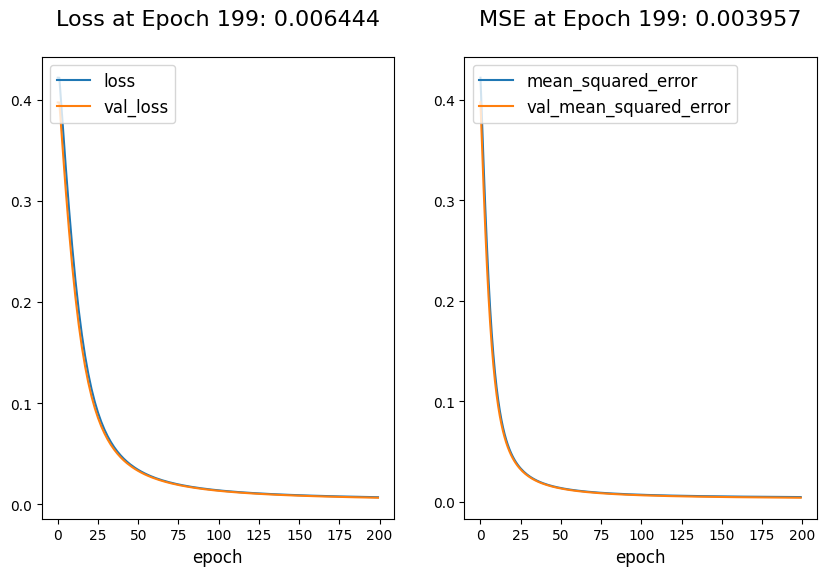

> training time is 2.1686 minutes


In [ ]:
history = []
for i in range(len(x_exp2_train)):
    print(f"Train id: {i}")
    temp_history = train_model(i, x_exp2_train[i], y_exp2_train[i], x_exp2_valid, y_exp2_valid, nb_epochs = 200)
    history.append(temp_history)
# for

4.4. Evaluating

In [ ]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
sizes = list(range(200, 2001, 200))

In [ ]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at size={sizes[vt_min]} with error = {errors[vt_min]}")

Min Error at size=2000 with error = 0.00395731208845973


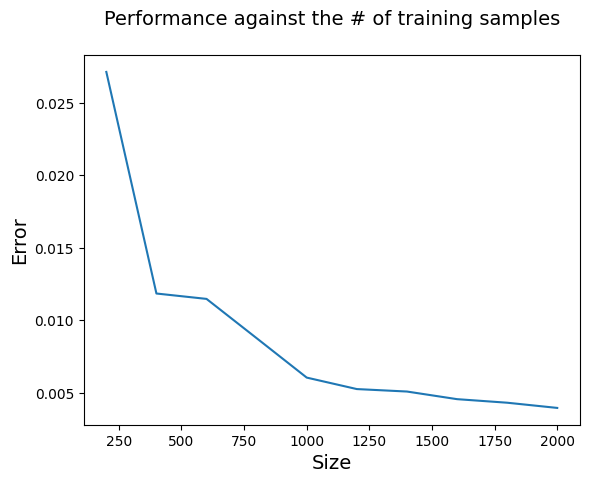

In [ ]:
plt.plot(sizes, errors)
plt.xlabel("Size", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("Performance against the # of training samples\n", fontsize = 14);

### 4.5. Discussion
Performance enhancing with increasing the sample sizes

The maximize at size = 1800 with error = 0.00417269766330719

# 5. EXPERIMENT 3:

Setup:

E* = 200

H = 1 - 10

N = 1800

5.1. Train Data

Train: x-shape = (1800, 2) y-shape = (1800,)
Valid: x-shape = (100, 2) y-shape = (100,)


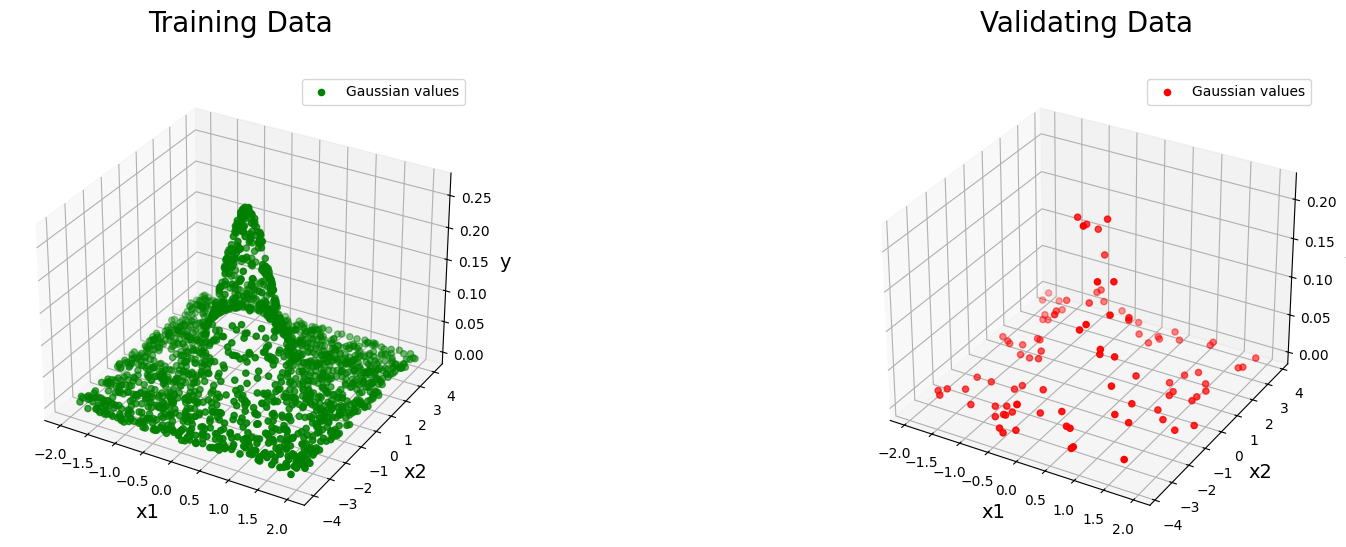

In [ ]:
x_exp3_train, y_exp3_train = x_train[:1800], y_train[:1800]
x_exp3_valid, y_exp3_valid = x_valid, y_valid

print(f"Train: x-shape = {x_exp3_train.shape} y-shape = {y_exp3_train.shape}")
print(f"Valid: x-shape = {x_exp3_valid.shape} y-shape = {y_exp3_valid.shape}")

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,2,1, projection='3d')
visualize_dataset(x_exp3_train, y_exp3_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,2,2, projection='3d')
visualize_dataset(x_exp3_valid, y_exp3_valid, color = "red", title = "Validating Data\n", ax = ax2)

5.2. Model

In [ ]:
exp3_model = build_model(H=10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

5.3. Training

In [ ]:
def train_model(train_id, x_local_train, y_local_train, x_local_valid, y_local_valid, n_hidden = 10, nb_epochs = 1000):

    K.clear_session()
    exp3_model = build_model(H=n_hidden)

    # OPTIMIZATION
    exp3_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"./data/model/train_03/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(filepath = os.path.join(save_dir, template_name),
                                               monitor='val_loss',
                                               verbose=0,
                                               save_best_only=True,
                                               save_weights_only=False, # only weight,
                                               mode='auto', # min, max, auto
                                              )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"],
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                           "style": "median"},
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False,
                             save_path = os.path.join(f"./data/model/train_03/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = exp3_model.fit(x_local_train, y_local_train,
                        validation_data=(x_local_valid, y_local_valid),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = callbacks,
                        verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history
# train_model

Train id: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

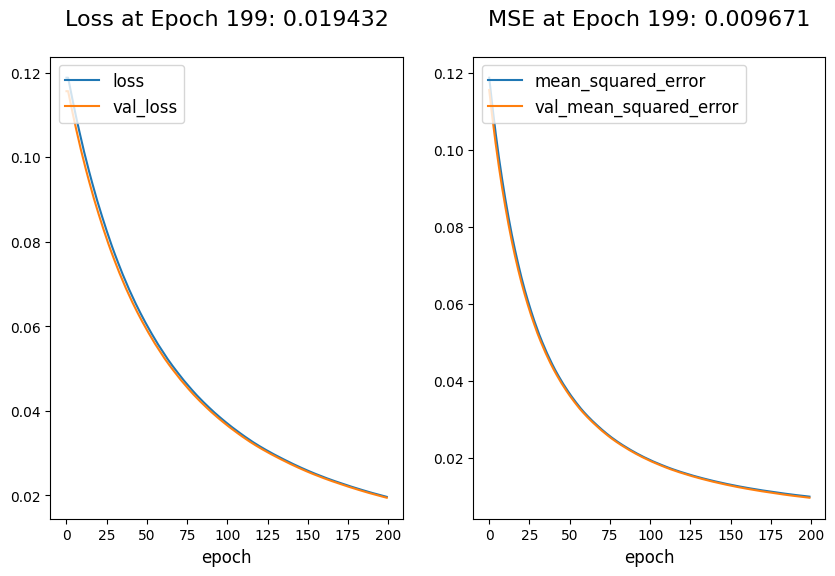

> training time is 2.2627 minutes
Train id: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

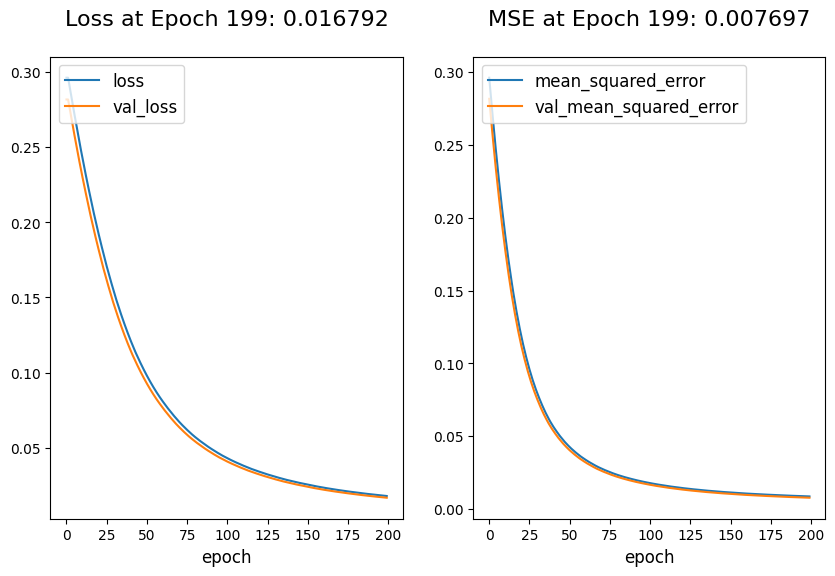

> training time is 2.2382 minutes
Train id: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

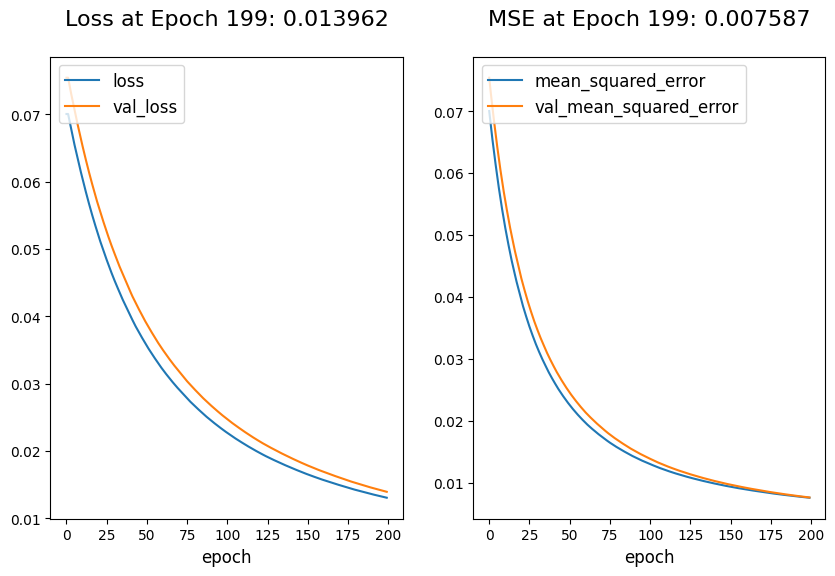

> training time is 2.2571 minutes
Train id: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

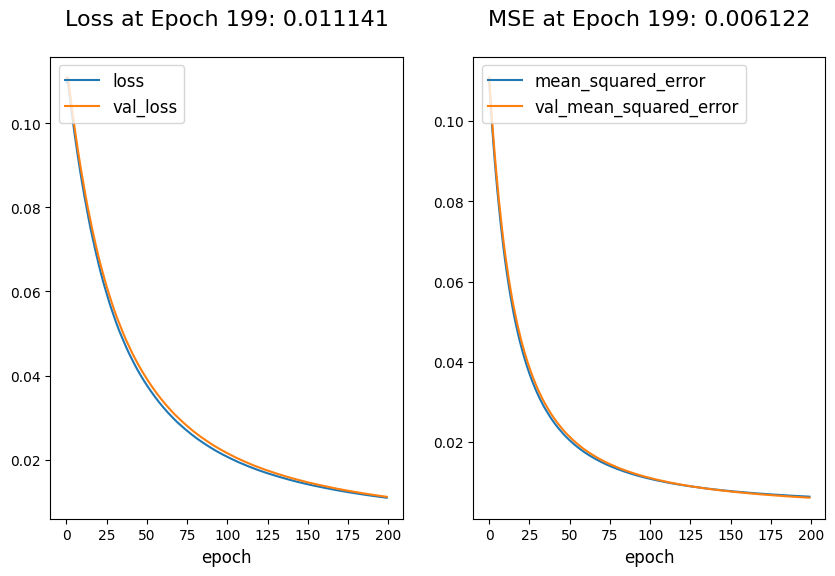

> training time is 2.2208 minutes
Train id: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 5)                   │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

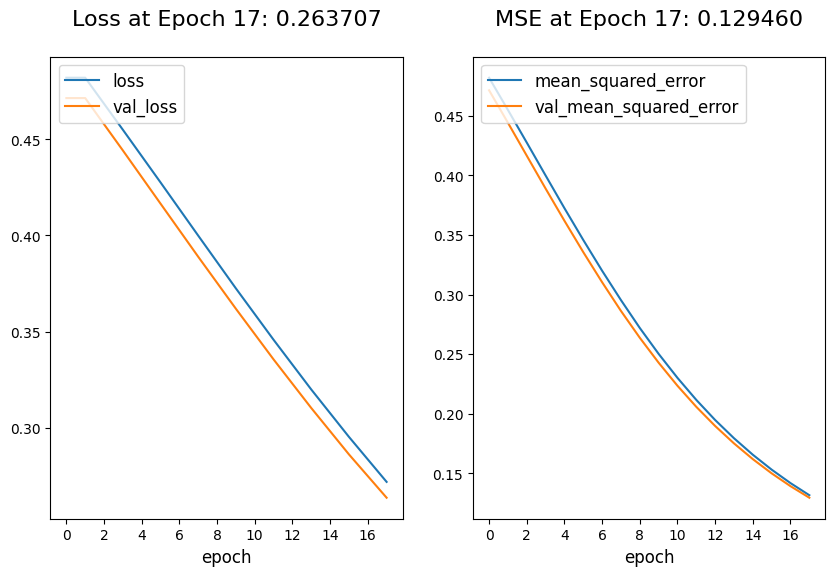

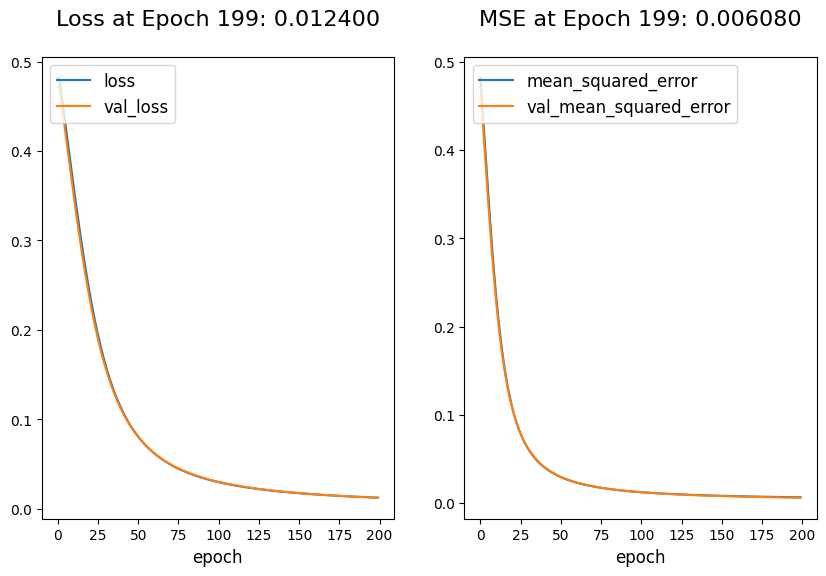

> training time is 2.1537 minutes
Train id: 6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 6)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

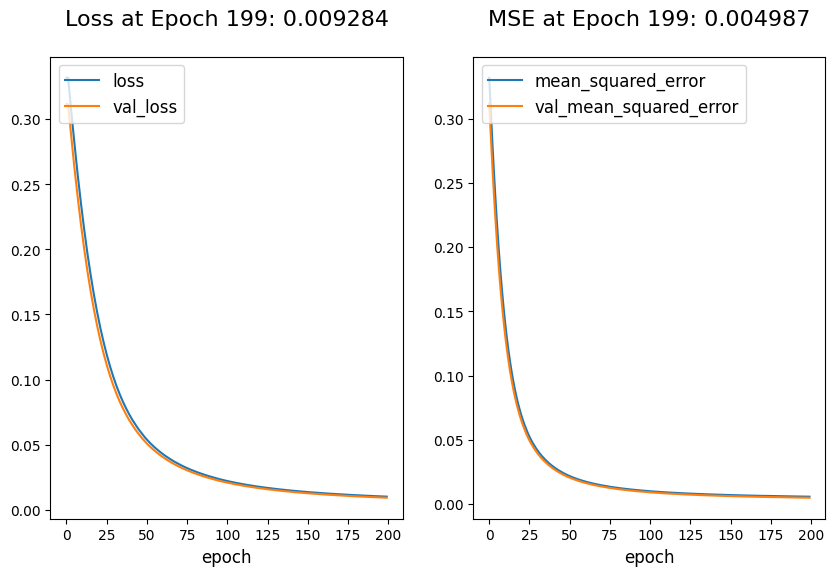

> training time is 2.1700 minutes
Train id: 7


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 7)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

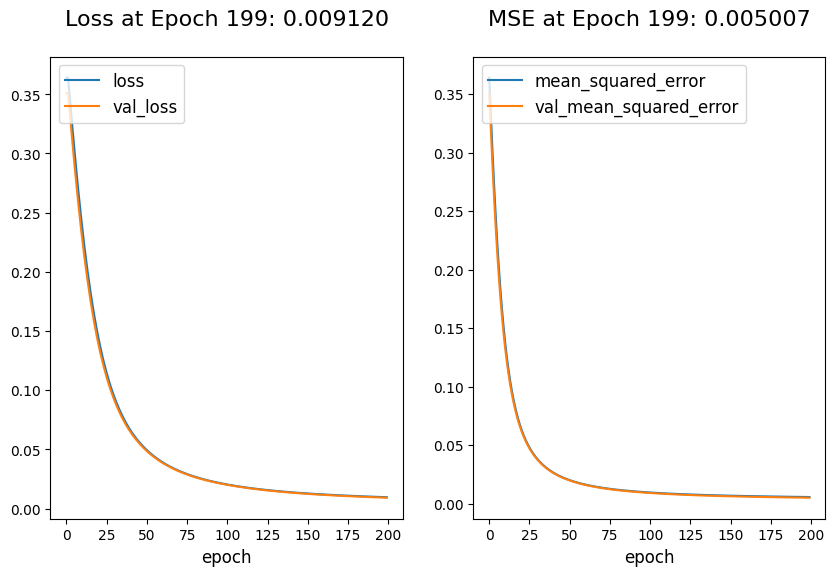

> training time is 2.2313 minutes
Train id: 8


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

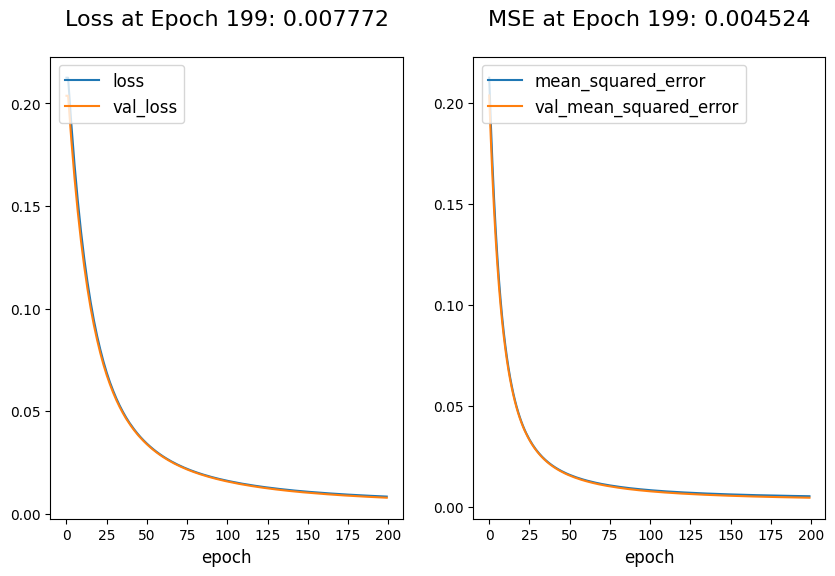

> training time is 2.2162 minutes
Train id: 9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 9)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

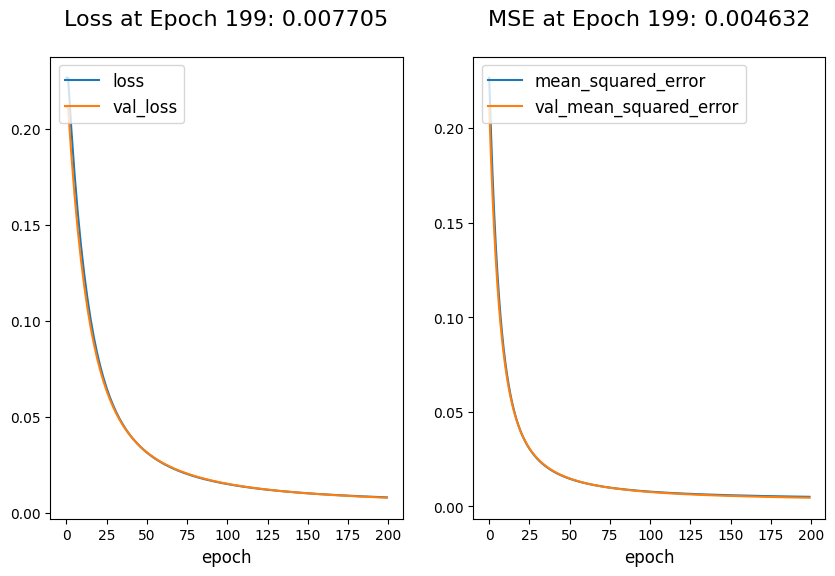

> training time is 2.1586 minutes
Train id: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gauss_apxm (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

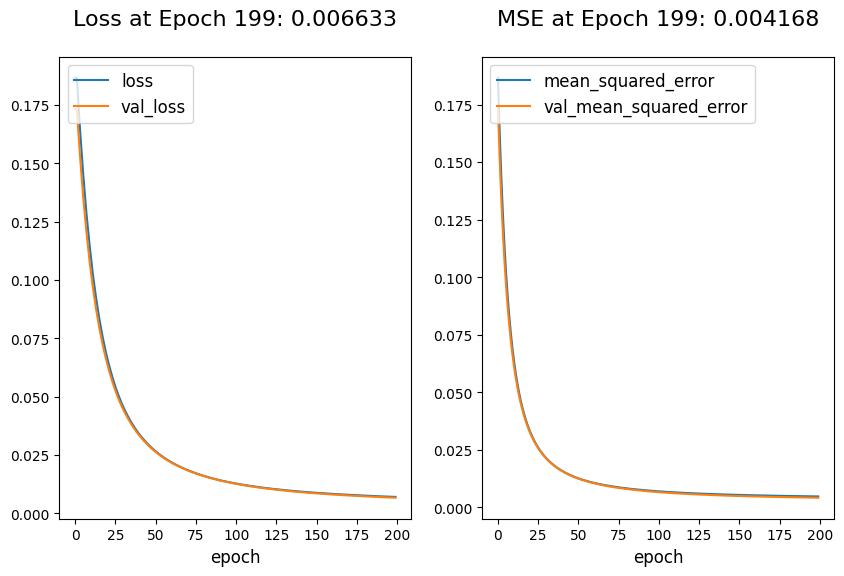

> training time is 2.2038 minutes


In [ ]:
history = []
for i in range(1, 11, 1):
    print(f"Train id: {i}")
    temp_history = train_model(i, x_exp3_train, y_exp3_train, x_exp3_valid, y_exp3_valid, n_hidden=i, nb_epochs = 200)
    history.append(temp_history)
# for

5.4. Evaluating

In [ ]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
hiddens = list(range(1, 11, 1))

In [ ]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at n_hidden={hiddens[vt_min]} with error = {errors[vt_min]}")

Min Error at n_hidden=10 with error = 0.004168079700320959


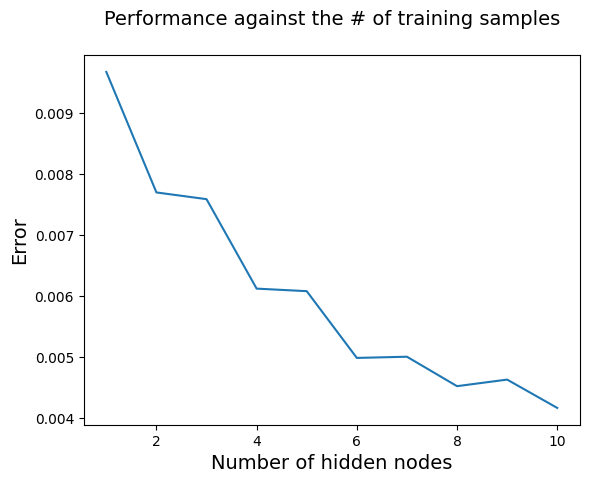

In [ ]:
plt.plot(hiddens, errors)
plt.xlabel("Number of hidden nodes", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("Performance against the # of training samples\n", fontsize = 14);

# 5.5. Discussion
Performance enhancing with increasing the hidden nodes

The maximize with number of hidden nodes 10 with error = 0.004637713078409433

# 6. EXPERIMENT 4:

Setup:

E* = 200

H = 10

L = 1 -> 10

N = 20000

##6.1 Train data

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Layers: 1, Train Loss: 0.0002, Val Loss: 0.0001
Layers: 2, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 3, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 4, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 5, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 6, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 7, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 8, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 9, Train Loss: 0.0000, Val Loss: 0.0000
Layers: 10, Train Loss: 0.0000, Val Loss: 0.0000


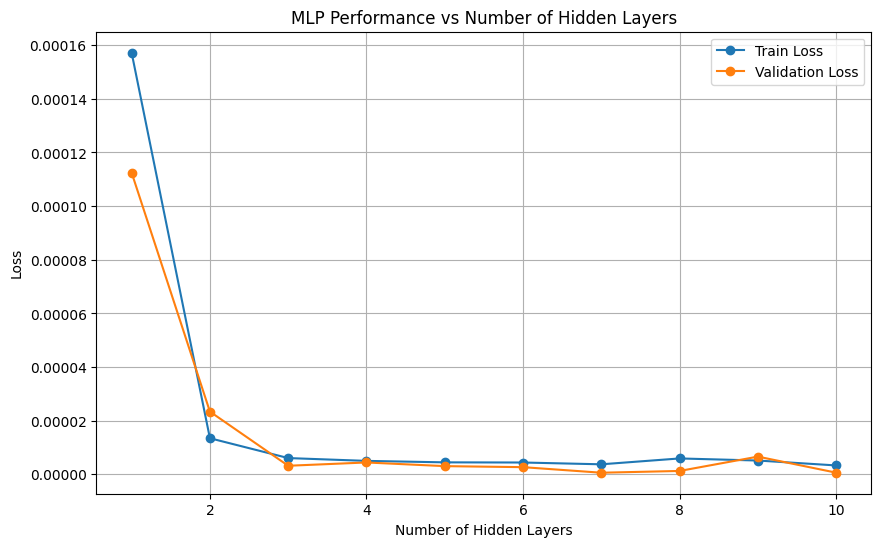

In [ ]:
import tensorflow as tf
import numpy as np
import csv
import matplotlib.pyplot as plt

# Parameters of MLP
n_input = 2
n_classes = 1
n_hiddens = [10] * 20  # Tối đa 20 lớp ẩn, mỗi lớp 10 node

# Parameters of Training
learning_rate = 0.01
batch_size = 32
epochs = 100
step_size = 1
from_size = 1
final_size = 10

# Generate synthetic data (example)
# np.random.seed(42)
# x_train = np.random.rand(1000, n_input).astype(np.float32)
# y_train = (x_train[:, 0] * 2 + x_train[:, 1] * -3 + 1).reshape(-1, 1)
# x_test = np.random.rand(200, n_input).astype(np.float32)
# y_test = (x_test[:, 0] * 2 + x_test[:, 1] * -3 + 1).reshape(-1, 1)

def build_mlp(n_input, n_classes, n_layers, n_hiddens):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(n_input,)))

    for i in range(n_layers):
        model.add(tf.keras.layers.Dense(n_hiddens[i], activation='relu'))

    model.add(tf.keras.layers.Dense(n_classes))  # Output layer
    return model

def experiment(save_image='experiment_results.png', log_file_name='experiment_log.csv'):
    # Open log files
    with open(log_file_name, 'w', newline='') as log_file:
        csv_log_file = csv.writer(log_file, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        csv_log_file.writerow(['size', 'train_loss', 'val_loss'])

        train_losses = []
        val_losses = []

        # Iterate over different numbers of hidden layers
        for size in range(from_size, final_size + 1, step_size):
            # Build model
            model = build_mlp(n_input, n_classes, size, n_hiddens)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='mse', metrics=['mse'])

            # Train model
            history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                                batch_size=batch_size, epochs=epochs, verbose=0)

            # Record losses
            train_loss = history.history['loss'][-1]
            val_loss = history.history['val_loss'][-1]
            train_losses.append((size, train_loss))
            val_losses.append((size, val_loss))

            # Log to CSV
            csv_log_file.writerow([size, train_loss, val_loss])
            print(f"Layers: {size}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot results
    sizes = [x[0] for x in train_losses]
    train_loss_vals = [x[1] for x in train_losses]
    val_loss_vals = [x[1] for x in val_losses]

    plt.figure(figsize=(10, 6))
    plt.plot(sizes, train_loss_vals, label='Train Loss', marker='o')
    plt.plot(sizes, val_loss_vals, label='Validation Loss', marker='o')
    plt.xlabel('Number of Hidden Layers')
    plt.ylabel('Loss')
    plt.title('MLP Performance vs Number of Hidden Layers')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_image)
    plt.show()

# Run the experiment
experiment()


# 7. EXPERIMENT 5:

Setup:

E* = 200

H = 1 -> 4

L = 1 -> 4

N = 20000

##7.1 Train data

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import itertools
import numpy as np
from IPython import display

# Giả sử bạn đã có hàm load_dataset() để load dữ liệu từ các file CSV
# x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

# Tạo danh sách các cấu hình hidden layers từ 0 đến 5 (5 chữ số)
# Tạo các cấu hình lớp ẩn
hidden_layer_configs = list(itertools.product(range(5), repeat=4))

# Chuyển các số khác 0 về bên trái và loại bỏ các cấu hình trùng lặp
rearranged_configs = [tuple(sorted(config, key=lambda x: x == 0)) for config in hidden_layer_configs]

# Loại bỏ các cấu hình trùng lặp
unique_configs = list(set(rearranged_configs))

# Sắp xếp lại kết quả để dễ đọc
unique_configs.sort()

# print(unique_configs)

# Lọc các cấu hình chỉ giữ lại những cấu hình có ít nhất một lớp ẩn với số node > 0
filtered_configs = [config for config in unique_configs if any(nodes > 0 for nodes in config)]

# Hàm tạo model
def create_model(config):
    model = Sequential()
    model.add(Dense(2, input_dim=2, activation='sigmoid'))  # Lớp input với 2 node

    # Lọc và loại bỏ các giá trị 0, chỉ giữ lại các lớp có số node khác 0
    filtered_config = [nodes for nodes in config if nodes > 0]

    # Thêm các lớp ẩn
    for nodes in filtered_config:
        model.add(Dense(nodes, activation='sigmoid'))

    # Lớp output với 1 node
    model.add(Dense(1, activation='sigmoid'))
    return model

# Tạo danh sách các model và tính toán MSE cho mỗi mô hình
mse_values = []  # Lưu trữ MSE của mỗi mô hình
node_counts = []  # Lưu trữ cấu hình số node của các lớp ẩn
count = len(filtered_configs)
for config in filtered_configs:
    model = create_model(config)

    # Biên dịch và huấn luyện mô hình
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=10, batch_size=225, verbose=0)  # Huấn luyện mô hình

    # Đánh giá mô hình trên tập validation để tính MSE
    mse = model.evaluate(x_valid, y_valid, verbose=0)
    display.clear_output()
    print(count)
    count = count - 1
    # Lưu lại MSE và cấu hình số node của các lớp ẩn
    mse_values.append(mse)
    filtered_config = [nodes for nodes in config if nodes > 0]
    node_counts.append(filtered_config)  # Lưu cấu hình đã lọc vào node_counts


# Chuẩn bị dữ liệu cho kết quả
mse_and_layers = []


# Lấy tất cả MSE và các lớp ẩn, tạo cấu trúc [MSE, hidden_layer_1, hidden_layer_2, ..., hidden_layer_5]
for i, nodes in enumerate(node_counts):
    nodes = nodes + [0] * (4 - len(nodes))  # Thêm các lớp ẩn với 0 nếu thiếu lớp
    mse_and_layers.append([mse_values[i]] + nodes)  # Thêm MSE vào đầu


# Chuyển đổi thành mảng numpy để dễ dàng xuất
mse_and_layers = np.array(mse_and_layers)

# Xuất kết quả dưới dạng (MSE, số node hidden layer 1, số node hidden layer 2, ...)
# for row in mse_and_layers:
#     print(tuple(row))  # Xuất mỗi dòng dưới dạng tuple


1


In [ ]:
import numpy as np

# Giả sử mse_and_layers là một list, ta chuyển nó thành numpy array
mse_and_layers = np.array(mse_and_layers)  # Chuyển đổi thành numpy array

# Tách cột MSE ra
mse_column = mse_and_layers[:, 0]  # Cột MSE
layers_column = mse_and_layers[:, 1:]  # Các lớp ẩn

# Loại bỏ trùng lặp trên các lớp ẩn (mà không xét MSE)
unique_layers = np.unique(layers_column, axis=0)

# Ghép lại cột MSE với các lớp ẩn duy nhất
unique_mse_and_layers = np.column_stack((mse_column[:len(unique_layers)], unique_layers))

# Xuất kết quả dưới dạng (MSE, số node hidden layer 1, số node hidden layer 2, ...)
# for row in unique_mse_and_layers:
#     print(tuple(row))  # Xuất mỗi dòng dưới dạng tuple


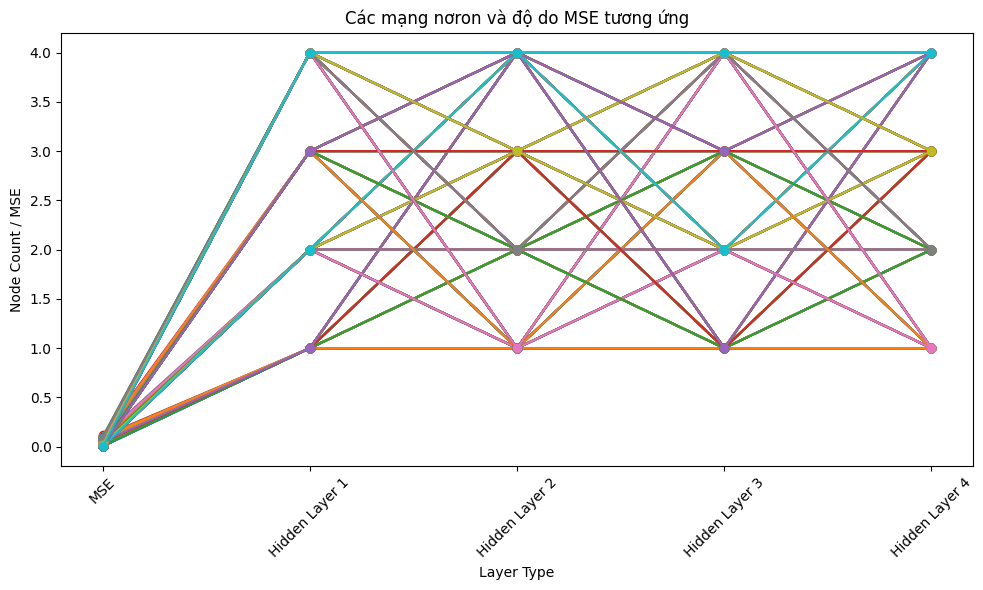

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử mse_and_layers là mảng numpy chứa các kết quả
# Mỗi dòng có dạng (MSE, hidden_layer_1, hidden_layer_2, hidden_layer_3, hidden_layer_4, hidden_layer_5)
# Ví dụ: mse_and_layers = np.array([[0.1, 3, 5, 0, 0, 0], [0.2, 4, 0, 0, 0, 0], ...])

# Lọc các giá trị nhỏ hơn hoặc bằng 0 ra khỏi dữ liệu
mse_and_layers_filtered = np.where(unique_mse_and_layers > 0, unique_mse_and_layers, np.nan)  # Thay các giá trị <= 0 thành NaN

# Định nghĩa các cột
# columns = ['MSE', 'Hidden Layer 1', 'Hidden Layer 2', 'Hidden Layer 3', 'Hidden Layer 4', 'Hidden Layer 5']
columns = ['MSE', 'Hidden Layer 1', 'Hidden Layer 2', 'Hidden Layer 3', 'Hidden Layer 4']

# Vẽ parallel line plot
fig, ax = plt.subplots(figsize=(10, 6))

# Số lượng mô hình (dòng dữ liệu)
num_models = mse_and_layers_filtered.shape[0]

# Tạo các đường song song cho mỗi mô hình, bỏ qua NaN
for i in range(num_models):
    ax.plot(columns, mse_and_layers_filtered[i], marker='o')  # Mỗi mô hình là một đường, không có label cho chú thích

# Cấu hình đồ thị
ax.set_title('Các mạng nơron và độ do MSE tương ứng')
ax.set_xlabel('Layer Type')
ax.set_ylabel('Node Count / MSE')

# Hiển thị đồ thị
plt.xticks(rotation=45)  # Xoay nhãn trục x nếu cần
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Giả sử mse_and_layers_filtered đã được tạo ra trước đó (với các giá trị NaN đã được thay thế)

# Tìm chỉ số của dòng có MSE nhỏ nhất
min_mse_index = np.nanargmin(mse_and_layers_filtered[:, 0])  # Cột đầu tiên chứa MSE

# Xuất dòng có MSE nhỏ nhất
best_model = mse_and_layers_filtered[min_mse_index]

# In ra kết quả
print("best_model:")
print(best_model)


best_model:
[3.16364947e-03 3.00000000e+00 3.00000000e+00 4.00000000e+00
            nan]


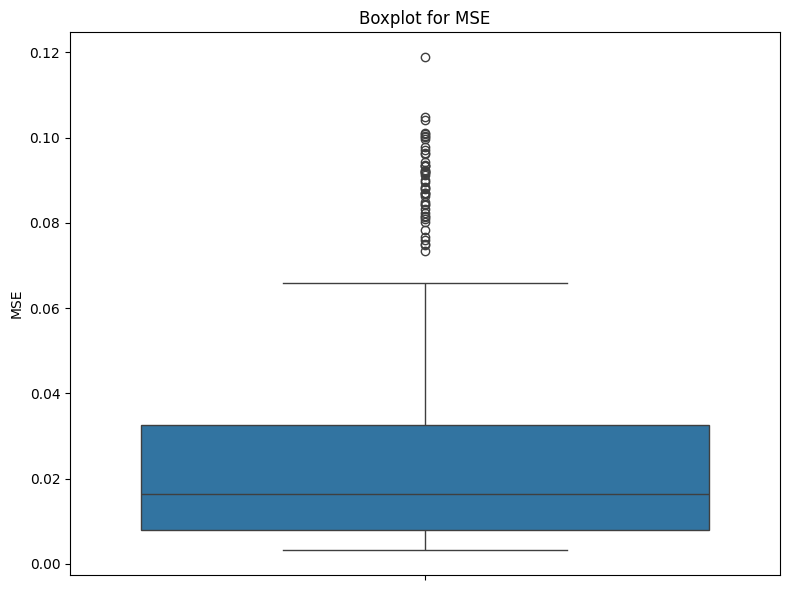

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Giả sử mse_and_layers_filtered đã được tạo ra trước đó

# Lấy cột MSE từ mảng và bỏ qua các giá trị NaN
mse_values = mse_and_layers_filtered[:, 0]  # Cột MSE (cột đầu tiên)

# Vẽ boxplot cho MSE
plt.figure(figsize=(8, 6))
sns.boxplot(y=mse_values)

# Cấu hình đồ thị
plt.title('Boxplot for MSE')
plt.ylabel('MSE')

# Hiển thị đồ thị
plt.tight_layout()
plt.show()


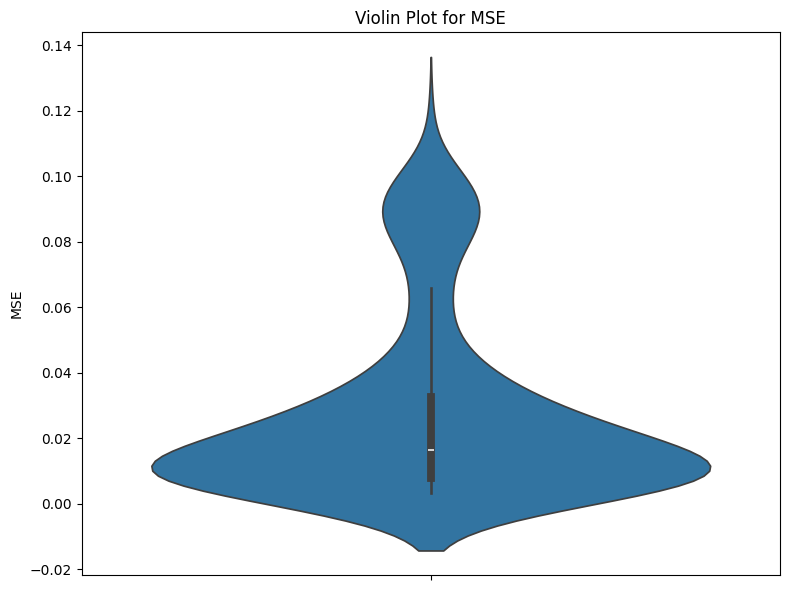

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Giả sử mse_and_layers_filtered đã được tạo ra trước đó

# Lấy cột MSE từ mảng và bỏ qua các giá trị NaN
mse_values = mse_and_layers_filtered[:, 0]  # Cột MSE (cột đầu tiên)

# Vẽ violin plot cho MSE
plt.figure(figsize=(8, 6))
sns.violinplot(y=mse_values)

# Cấu hình đồ thị
plt.title('Violin Plot for MSE')
plt.ylabel('MSE')

# Hiển thị đồ thị
plt.tight_layout()
plt.show()
